In [1]:
!pip install pymc3

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas_profiling import ProfileReport
import pymc3 as pm
from sklearn.linear_model import LinearRegression

%matplotlib inline

# import data - データの読み込み

In [3]:
df_videos = pd.read_csv(os.path.join('..', 'data', 'AIcia_videos_20210410.csv'))
df_videos['公開日時'] = pd.to_datetime(df_videos['公開日時'])
df_videos['動画時間_s'] = pd.to_timedelta(df_videos['動画時間']).apply(lambda x: x.seconds)

df_videos = df_videos.drop(['動画時間'], axis=1)

df_videos.head()

動画タイトル       公開日時  経過日数  プレミア公開  \
0  【深層学習】fasttext - 単語の内部構造を利用した版 word2vec 【ディープラ... 2021-04-09     1       1   
1  【登壇するよ！】Developer eXperience Day 2021【無料！聞きに来て... 2021-04-02     8       1   
2  【深層学習】Attention - 全領域に応用され最高精度を叩き出す注意機構の仕組み【ディ... 2021-03-26    15       1   
3  【ラグランジュの未定乗数法】あの計算の意味、説明できますか？【幾何的イメージも解説】#094... 2021-03-19    22       1   
4  【深層学習】doc2vec - 文章の意味を機械が理解する仕組み【ディープラーニングの世界 ... 2021-03-05    36       1   

   視聴回数  コメント  高評価件数  低評価件数   ln_経過日数   ln_視聴回数  ln_高評価件数  動画時間_s  
0   420     2     22      0  0.000000  6.040255  3.091042    1225  
1  1005     0     44      1  2.079442  6.912743  3.784190     488  
2  9504    47    427      2  2.708050  9.159468  6.056784    2197  
3  3234    27    220      0  3.091042  8.081475  5.393628    1922  
4  1567    17     60      1  3.583519  7.356918  4.094345    1199

In [4]:
profile = ProfileReport(df_videos, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [5]:
profile

# Hierarchical Bayesian Modeling

In [6]:
n_videos = len(df_videos)

In [7]:
# define model and sample

with pm.Model() as model:
    # prior to parameters
    alpha_plus = pm.Normal('alpha_plus', mu=-3, sd=2)
    beta_plus = pm.TruncatedNormal('beta_plus', mu=0, sd=1, lower=0)
    alpha_minus = pm.Normal('alpha_minus', mu=-3, sd=2)
    beta_minus = pm.TruncatedNormal('beta_minus', mu=0, sd=1, upper=0)
    
    # prior to fun
    fun = pm.Normal('fun', mu=0, sd=1, shape=n_videos)
    
    # play
    play = df_videos['視聴回数']
    
    # +1 and -1
    lambda_plus = pm.math.exp((alpha_plus + beta_plus * fun)) * play
    like = pm.Poisson('like', mu=lambda_plus, observed=df_videos['高評価件数'])
    
    lambda_minus = pm.math.exp((alpha_minus + beta_minus * fun)) * play
    dislike = pm.Poisson('dislike', mu=lambda_minus, observed=df_videos['低評価件数'])
    
    trace = pm.sample(1500, tune=1000, chains=5, random_seed=57)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [fun, beta_minus, alpha_minus, beta_plus, alpha_plus]


Sampling 5 chains for 1_000 tune and 1_500 draw iterations (5_000 + 7_500 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13e685750>,
      dtype=object)

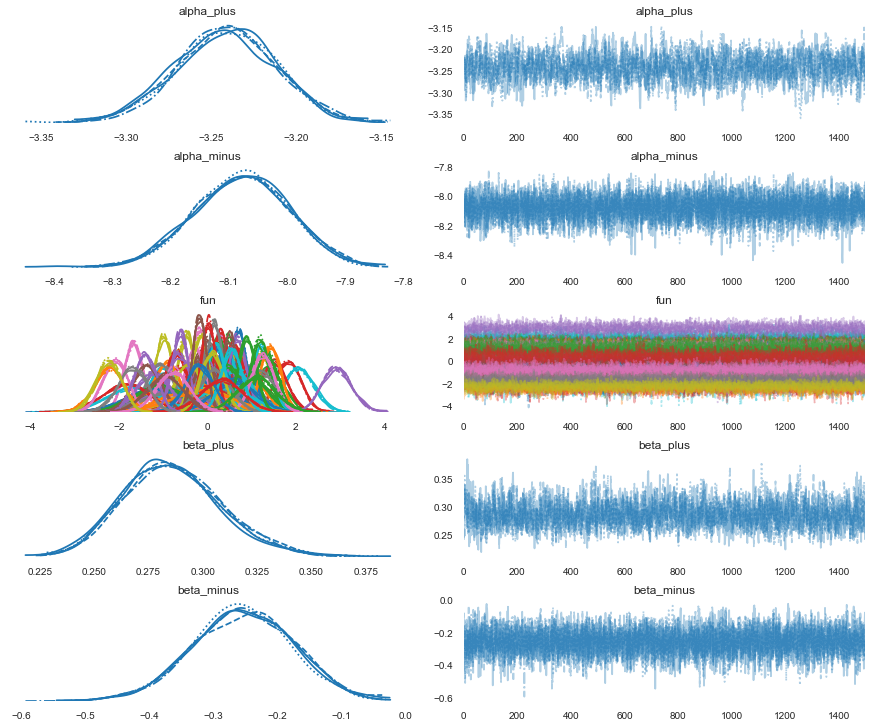

In [8]:
pm.traceplot(trace)

In [9]:
df_trace = pm.summary(trace)

df_trace

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
alpha_plus  -3.241  0.029  -3.295   -3.187      0.001    0.001    1041.0   
alpha_minus -8.078  0.081  -8.225   -7.923      0.001    0.001    6091.0   
fun[0]       0.609  0.640  -0.665    1.759      0.005    0.006   15617.0   
fun[1]       0.245  0.488  -0.659    1.148      0.005    0.006   10799.0   
fun[2]       0.471  0.198   0.095    0.838      0.003    0.002    3261.0   
...            ...    ...     ...      ...        ...      ...       ...   
fun[106]    -0.779  0.360  -1.429   -0.069      0.004    0.003    7361.0   
fun[107]    -1.699  0.327  -2.338   -1.114      0.005    0.003    4878.0   
fun[108]    -2.234  0.283  -2.777   -1.725      0.005    0.004    2723.0   
beta_plus    0.286  0.022   0.248    0.332      0.001    0.000    1453.0   
beta_minus  -0.254  0.078  -0.401   -0.110      0.001    0.001    6085.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
alpha_plus   1041.0    1041.0    1801.0    1.0  
alpha_minus  6082.0    6119.0    5315.0    1.0  
fun[0]       5847.0   15696.0    5035.0    1.0  
fun[1]       3508.0   10764.0    4831.0    1.0  
fun[2]       3261.0    3252.0    4182.0    1.0  
...             ...       ...       ...    ...  
fun[106]     6218.0    7353.0    4652.0    1.0  
fun[107]     4808.0    4877.0    4983.0    1.0  
fun[108]     2723.0    2721.0    4123.0    1.0  
beta_plus    1451.0    1459.0    2357.0    1.0  
beta_minus   6085.0    5990.0    4092.0    1.0  

[113 rows x 11 columns]

In [10]:
model_map = pm.find_MAP(model=model)
model_map

{'alpha_plus': array(-3.27139177),
 'beta_plus_lowerbound__': array(0.46203181),
 'alpha_minus': array(-8.04120887),
 'beta_minus_upperbound__': array(0.21670208),
 'fun': array([ 0.20159716,  0.08134322,  0.10697296,  0.36843312,  0.00145403,
         0.22667032,  0.16861176,  0.18138841,  0.2491966 ,  0.42412698,
         0.05895517,  0.20355468,  0.29811169,  0.3117554 ,  0.57942088,
        -0.0018805 , -0.02861498,  0.00548124, -0.01439876,  0.1462585 ,
         0.17032176,  0.01030395,  0.2175137 ,  0.01208798,  0.10310488,
         0.04767103,  0.10482774,  0.07726877,  0.15731194,  0.24953646,
         0.05360197,  0.04032394,  0.2745915 ,  0.13508342,  0.09258802,
         0.02123184,  0.07241635,  0.03552155, -0.10706614,  0.09737532,
         0.14916564,  0.28574026,  0.06659232,  0.07639861,  0.14803894,
         0.1134135 , -0.0117187 ,  0.05161861, -0.06771484,  0.15083245,
         0.0763127 , -0.05309375,  0.1128666 , -0.10365009,  0.00987764,
        -0.00386242, -0.03

In [11]:
df_trace.loc['fun[0]':'beta_plus', ['mean']].sort_values('mean', ascending=False)

mean
fun[14]   2.932
fun[9]    2.084
fun[3]    1.835
fun[13]   1.508
fun[41]   1.440
...         ...
fun[107] -1.699
fun[83]  -1.852
fun[86]  -2.087
fun[101] -2.226
fun[108] -2.234

[110 rows x 1 columns]

In [12]:
# top 5 "fun" videos

df_videos.iloc[[14, 9, 3, 13, 41]]

動画タイトル       公開日時  経過日数  \
14  【射影幾何】バラバラな3つの定義を統一！ 射影幾何の面白さに入門しよう【2次曲線】 #083... 2020-11-20   141   
9   【因子分析】因子の回転ってなんだ！？【新たな視点で因子をより深く理解する】 #088 #VR... 2021-01-22    78   
3   【ラグランジュの未定乗数法】あの計算の意味、説明できますか？【幾何的イメージも解説】#094... 2021-03-19    22   
13  【自然言語処理】tf-idf 単語の情報量を加味した類似度分析【Elasticsearch ... 2020-12-04   127   
41  【偽物の相関を見極めろ！】グラフィカルモデリングで変数の相関関係を把握する【いろんな分析 v... 2020-05-17   328   

    プレミア公開  視聴回数  コメント  高評価件数  低評価件数   ln_経過日数   ln_視聴回数  ln_高評価件数  動画時間_s  
14       1  2131    42    203      0  4.948760  7.664347  5.313206    1252  
9        1  2124    11    158      0  4.356709  7.661056  5.062595    1294  
3        1  3234    27    220      0  3.091042  8.081475  5.393628    1922  
13       1  2719    10    169      0  4.844187  7.908019  5.129899    1011  
41       1  7614    62    456      3  5.793014  8.937744  6.122493    1905

In [13]:
# worst 5 "fun" videos

df_videos.iloc[[108, 83, 86, 101, 107]]

動画タイトル       公開日時  経過日数  \
108      【自己紹介】はじめまして、アイシア=ソリッドです！【Hello, world!】 #000 2018-06-23  1022   
83   【1分 Google Spreadsheet 解説 1-1 】合計の計算から始めよう【 SU... 2019-03-25   747   
86      【時系列分析①】漸化式と線型代数その1【特性方程式の謎を解く！】 #VRアカデミア #023 2019-02-23   777   
101   【微分幾何】多様体の内在的な定義【本編にドーナツは一切登場しません】 #VRアカデミア #008 2018-09-24   929   
107  【AI界で流行中！？】人間の皆さんに、GANごっこをお伝えします【暇を持て余したAIの遊び】... 2018-06-24  1021   

     プレミア公開   視聴回数  コメント  高評価件数  低評価件数   ln_経過日数   ln_視聴回数  ln_高評価件数  動画時間_s  
108       0  12334    14    247      6  6.929517  9.420115  5.509388      96  
83        0   1514     8     28      0  6.616065  7.322510  3.332205      94  
86        1  12524    54    262      5  6.655440  9.435402  5.568345    1662  
101       0   7106    18    140      4  6.834109  8.868695  4.941642    1143  
107       0   5464    12    129      6  6.928538  8.605936  4.859812     280

# fun vs comment

In [14]:
with pm.Model() as model_with_comment:
    # prior to parameters
    alpha_plus = pm.Normal('alpha_plus', mu=-3, sd=2)
    beta_plus = pm.TruncatedNormal('beta_plus', mu=0, sd=1, lower=0)
    alpha_minus = pm.Normal('alpha_minus', mu=-3, sd=2)
    beta_minus = pm.TruncatedNormal('beta_minus', mu=0, sd=1, upper=0)
    alpha_comment = pm.Normal('alpha_comment', mu=-3, sd=2)
    beta_comment = pm.TruncatedNormal('beta_comment', mu=0, sd=1, lower=0)
    
    # prior to fun
    fun = pm.Normal('fun', mu=0, sd=1, shape=n_videos)
    
    # prior to comment
    latent_comment = pm.Normal('latent_comment', mu=0, sd=1, shape=n_videos)
    
    # play
    play = df_videos['視聴回数']
    
    # +1, -1, comment
    lambda_plus = pm.math.exp((alpha_plus + beta_plus * fun)) * play
    like = pm.Poisson('like', mu=lambda_plus, observed=df_videos['高評価件数'])
    
    lambda_minus = pm.math.exp((alpha_minus + beta_minus * fun)) * play
    dislike = pm.Poisson('dislike', mu=lambda_minus, observed=df_videos['低評価件数'])
    
    lambda_comment = pm.math.exp((alpha_comment + beta_comment * latent_comment)) * play
    comment = pm.Poisson('comment', mu=lambda_comment, observed=df_videos['コメント'])
    
    trace = pm.sample(1500, tune=1000, chains=5, random_seed=57)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [latent_comment, fun, beta_comment, alpha_comment, beta_minus, alpha_minus, beta_plus, alpha_plus]


Sampling 5 chains for 1_000 tune and 1_500 draw iterations (5_000 + 7_500 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x142652ed0>,
      dtype=object)

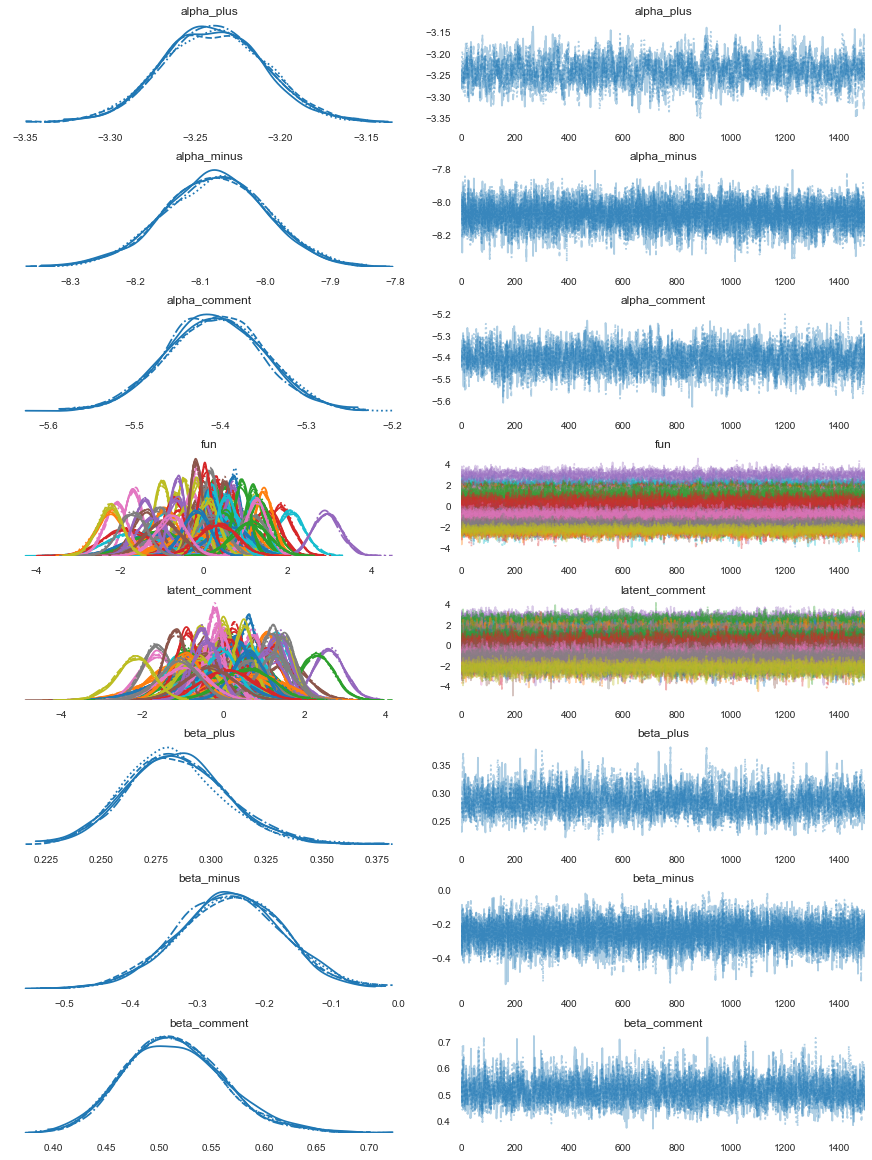

In [15]:
pm.traceplot(trace)

In [16]:
df_trace = pm.summary(trace)

df_trace

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_plus          -3.240  0.030  -3.292   -3.179      0.001    0.001   
alpha_minus         -8.078  0.079  -8.222   -7.924      0.001    0.001   
alpha_comment       -5.407  0.057  -5.508   -5.295      0.001    0.001   
fun[0]               0.620  0.630  -0.523    1.857      0.005    0.006   
fun[1]               0.239  0.477  -0.647    1.123      0.004    0.005   
...                    ...    ...     ...      ...        ...      ...   
latent_comment[107] -1.120  0.483  -2.050   -0.250      0.004    0.004   
latent_comment[108] -2.201  0.452  -3.094   -1.391      0.005    0.004   
beta_plus            0.284  0.022   0.244    0.328      0.001    0.000   
beta_minus          -0.251  0.078  -0.403   -0.109      0.001    0.001   
beta_comment         0.516  0.047   0.429    0.603      0.001    0.001   

                     ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
alpha_plus              929.0   929.0     929.0    1764.0    1.0  
alpha_minus            5534.0  5526.0    5577.0    4657.0    1.0  
alpha_comment          2069.0  2069.0    2067.0    3304.0    1.0  
fun[0]                14145.0  5859.0   14625.0    4417.0    1.0  
fun[1]                11321.0  3943.0   11395.0    5130.0    1.0  
...                       ...     ...       ...       ...    ...  
latent_comment[107]   12241.0  7443.0   13043.0    4599.0    1.0  
latent_comment[108]    7676.0  7005.0    7875.0    5050.0    1.0  
beta_plus              1745.0  1745.0    1724.0    3105.0    1.0  
beta_minus             5879.0  5879.0    5818.0    3968.0    1.0  
beta_comment           2306.0  2306.0    2293.0    3618.0    1.0  

[224 rows x 11 columns]

In [17]:
df_latent = df_trace.loc['fun[0]':'latent_comment[62]', ['mean']].reset_index()
df_latent['variable'] = df_latent['index'].apply(lambda x: x.split('[')[0])
df_latent['index'] = df_latent['index'].apply(lambda x: x.split('[')[1].split(']')[0])
df_latent = df_latent.set_index(['index', 'variable']).unstack()

In [18]:
df_latent.describe()

mean               
variable         fun latent_comment
count     109.000000      63.000000
mean        0.002202       0.222413
std         0.927196       0.900533
min        -2.252000      -1.683000
25%        -0.629000      -0.454500
50%         0.026000       0.220000
75%         0.604000       0.739000
max         2.946000       2.610000

In [19]:
# correlation between "fun" and "tendency to comment"

df_latent.corr()

mean               
variable                  fun latent_comment
     variable                               
mean fun             1.000000       0.360309
     latent_comment  0.360309       1.000000

# Additional survey on dependency of #views on #likes/#views 

Text(0, 0.5, 'likes')

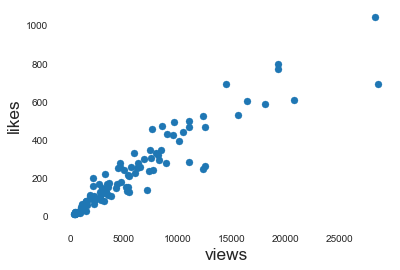

In [20]:
fig, ax = plt.subplots()

ax.scatter(df_videos['視聴回数'], df_videos['高評価件数'])
ax.set_xlabel('views', fontsize='xx-large')
ax.set_ylabel('likes', fontsize='xx-large')


Text(0, 0.5, 'ln_likes')

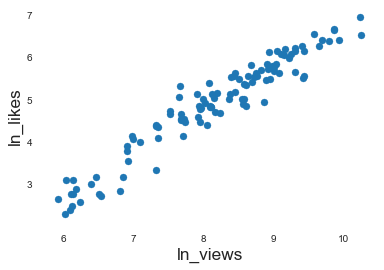

In [21]:
fig, ax = plt.subplots()

ax.scatter(df_videos['ln_視聴回数'], df_videos['ln_高評価件数'])
ax.set_xlabel('ln_views', fontsize='xx-large')
ax.set_ylabel('ln_likes', fontsize='xx-large')

Text(0, 0.5, 'ln_ln_likes')

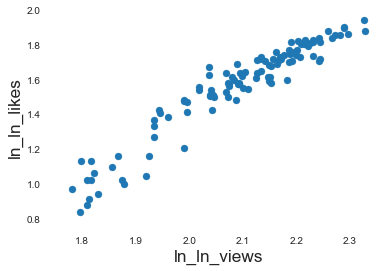

In [22]:
fig, ax = plt.subplots()

ax.scatter(np.log(df_videos['ln_視聴回数']), np.log(df_videos['ln_高評価件数']))
ax.set_xlabel('ln_ln_views', fontsize='xx-large')
ax.set_ylabel('ln_ln_likes', fontsize='xx-large')

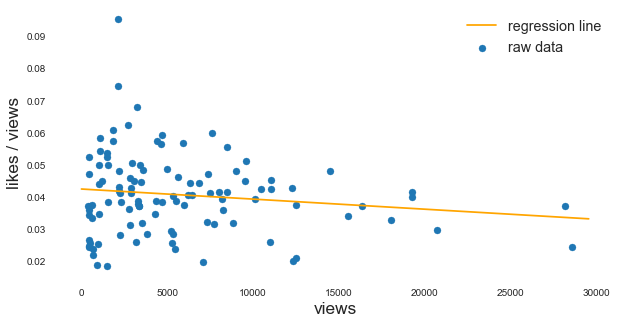

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))

data_x = df_videos[['視聴回数']]
data_y = df_videos['高評価件数']/df_videos['視聴回数']

x_linsp = np.linspace(0, data_x.max()+1000, 1000)

lm = LinearRegression()
lm.fit(data_x, data_y)

ax.plot(x_linsp, lm.predict(x_linsp), label='regression line', color='orange')
ax.scatter(data_x, data_y, label='raw data')
ax.set_xlabel('views', fontsize='xx-large')
ax.set_ylabel('likes / views', fontsize='xx-large')
ax.legend(fontsize='x-large')

やっぱり、再生数が大きいと、高評価割合が下がるような気がする（気がする）

この補正も入れて面白さ度合いを出してみよう！

# Hierarchical Bayesian Modeling with correction on the above effect

In [24]:
n_videos = len(df_videos)

In [25]:
# define model and sample

with pm.Model() as model:
    # prior to parameters
    alpha_plus = pm.Normal('alpha_plus', mu=-3, sd=2)
    beta_plus = pm.TruncatedNormal('beta_plus', mu=0, sd=1, lower=0)
    gamma_plus = pm.TruncatedNormal('gamma_plus', mu=0, sd=1, upper=0)
    alpha_minus = pm.Normal('alpha_minus', mu=-3, sd=2)
    beta_minus = pm.TruncatedNormal('beta_minus', mu=0, sd=1, upper=0)
    
    # prior to fun
    fun = pm.Normal('fun', mu=0, sd=1, shape=n_videos)
    
    # play
    play = df_videos['視聴回数']
    
    # +1 and -1
    lambda_plus = pm.math.exp(alpha_plus + beta_plus * fun + gamma_plus * play / 100000000) * play
    like = pm.Poisson('like', mu=lambda_plus, observed=df_videos['高評価件数'])
    
    lambda_minus = pm.math.exp(alpha_minus + beta_minus * fun) * play
    dislike = pm.Poisson('dislike', mu=lambda_minus, observed=df_videos['低評価件数'])
    
    trace = pm.sample(1500, tune=1000, chains=5, random_seed=57)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [fun, beta_minus, alpha_minus, gamma_plus, beta_plus, alpha_plus]


Sampling 5 chains for 1_000 tune and 1_500 draw iterations (5_000 + 7_500 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14545e750>,
      dtype=object)

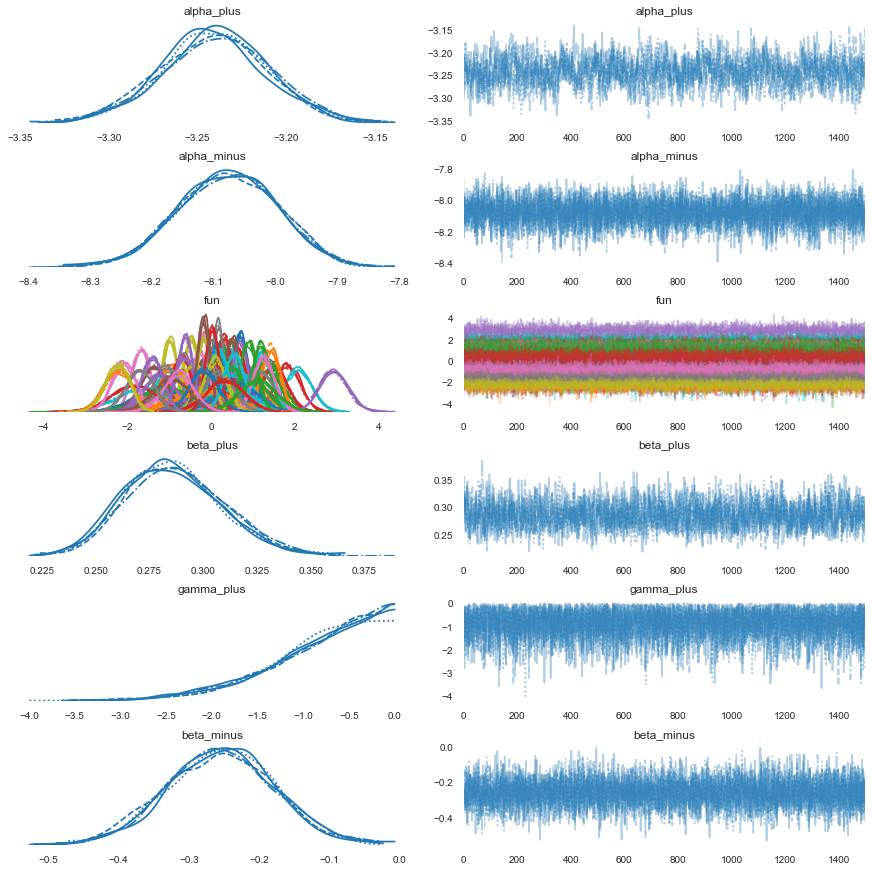

In [26]:
pm.traceplot(trace)

In [27]:
df_trace = pm.summary(trace)

df_trace

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
alpha_plus  -3.240  0.030  -3.295   -3.183      0.001    0.001     786.0   
alpha_minus -8.077  0.080  -8.225   -7.930      0.001    0.001    4760.0   
fun[0]       0.625  0.616  -0.516    1.795      0.005    0.006   13060.0   
fun[1]       0.235  0.484  -0.647    1.159      0.005    0.006   10013.0   
fun[2]       0.471  0.197   0.110    0.851      0.004    0.003    2465.0   
...            ...    ...     ...      ...        ...      ...       ...   
fun[107]    -1.702  0.326  -2.322   -1.107      0.005    0.003    4956.0   
fun[108]    -2.237  0.285  -2.788   -1.721      0.006    0.004    2667.0   
beta_plus    0.286  0.023   0.244    0.328      0.001    0.000    1724.0   
gamma_plus  -0.794  0.613  -1.907   -0.000      0.006    0.004    9374.0   
beta_minus  -0.254  0.076  -0.397   -0.110      0.001    0.001    5930.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
alpha_plus    786.0     788.0    1670.0    1.0  
alpha_minus  4760.0    4735.0    5677.0    1.0  
fun[0]       5810.0   12980.0    5472.0    1.0  
fun[1]       3311.0   10084.0    5227.0    1.0  
fun[2]       2465.0    2466.0    3920.0    1.0  
...             ...       ...       ...    ...  
fun[107]     4956.0    4908.0    4337.0    1.0  
fun[108]     2667.0    2627.0    4253.0    1.0  
beta_plus    1704.0    1771.0    3134.0    1.0  
gamma_plus   9374.0    6605.0    3942.0    1.0  
beta_minus   5930.0    5912.0    3844.0    1.0  

[114 rows x 11 columns]

In [28]:
model_map = pm.find_MAP(model=model)
model_map

{'alpha_plus': array(-3.27267844),
 'beta_plus_lowerbound__': array(0.46109984),
 'gamma_plus_upperbound__': array(-4.1752587),
 'alpha_minus': array(-8.04033005),
 'beta_minus_upperbound__': array(0.21732906),
 'fun': array([ 0.20267796,  0.0822048 ,  0.10787647,  0.36959039,  0.00224701,
         0.22771335,  0.16964025,  0.18235563,  0.25021997,  0.4253578 ,
         0.05981762,  0.20453332,  0.29923703,  0.31286319,  0.58079925,
        -0.00107309, -0.02783615,  0.0062854 , -0.01360907,  0.1472032 ,
         0.17129284,  0.01112748,  0.21850393,  0.01291798,  0.10400558,
         0.0485409 ,  0.1057284 ,  0.07814349,  0.15825462,  0.25058462,
         0.05446404,  0.04115825,  0.27565388,  0.13602113,  0.09348056,
         0.02205286,  0.07329423,  0.03634396, -0.10634525,  0.09828091,
         0.15010674,  0.28681247,  0.0674556 ,  0.07727486,  0.14897962,
         0.11432885, -0.01091884,  0.05248417, -0.06697333,  0.15178457,
         0.07718507, -0.05233229,  0.11375888, -0.10

In [29]:
df_trace.loc['fun[0]':'beta_plus', ['mean']].sort_values('mean', ascending=False)

mean
fun[14]   2.936
fun[9]    2.085
fun[3]    1.834
fun[13]   1.507
fun[41]   1.436
...         ...
fun[107] -1.702
fun[83]  -1.860
fun[86]  -2.086
fun[101] -2.230
fun[108] -2.237

[110 rows x 1 columns]

結果は変わらず。残念。